导入包

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

数据导入

预处理：将tr_date字段转为可被pandas识别的时间字段，并转换为datetime。将Date设置为index。

In [2]:
df = pd.read_csv('/Users/ryan/Documents/GitHub/GDHF-Quant-Investment/test_data/test_data_600111.csv', index_col=[0])
df['tr_date'] = df.tr_date.map(lambda x: str(x)) 
df['Date'] = df['tr_date'].str[:4]+'-'+df['tr_date'].str[4:6]+'-'+df['tr_date'].str[6:]
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.sort_index(inplace=True)
df.drop(['ori_index', 'tr_date'], axis=1, inplace=True)
df.head()

,predict,price
Date,,
2017-02-06,46.812157,49.12
2017-02-07,46.192360,50.16
2017-02-08,45.538500,48.25
2017-02-09,44.942000,48.70
2017-02-10,44.462643,47.27


In [3]:
df['return_true'] = df['price']/df['price'].shift(1)-1
df['return_predict'] = df['predict']/df['predict'].shift(1)-1
df.head(3)

,predict,price,return_true,return_predict
Date,,,,
2017-02-06,46.812157,49.12,NaN,NaN
2017-02-07,46.192360,50.16,0.021173,-0.013240
2017-02-08,45.538500,48.25,-0.038078,-0.014155


买入与卖出信号：  

预测第二天能涨（即收益率为正），在当天买入。卖出信号同理，预测第二天会跌时，在当天就执行卖出操作。

**后续可以优化的细节：** #! TO BE EXTENDED

In [4]:
df['buy_price'] = np.where(df['return_predict'].shift(-1)>0, df['price'], np.nan)
df['sell_price'] = np.where(df['return_predict'].shift(-1)<0, df['price'], np.nan)

将买入卖出点标记在真实股价变化图上

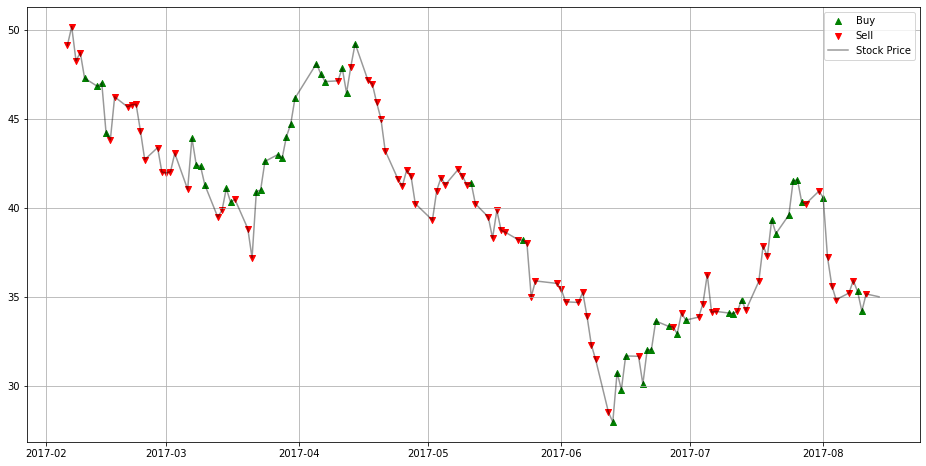

In [15]:
fig = plt.figure(figsize=(16,8))
plt.scatter(df.index, df['buy_price'], color='green', label='Buy', marker='^')
plt.scatter(df.index, df['sell_price'], color='red', label='Sell', marker='v')
plt.plot(df['price'], label='Stock Price', color='black', alpha=0.4)
plt.legend()
plt.grid()
plt.show()

收益率变化曲线

<AxesSubplot:xlabel='Date'>

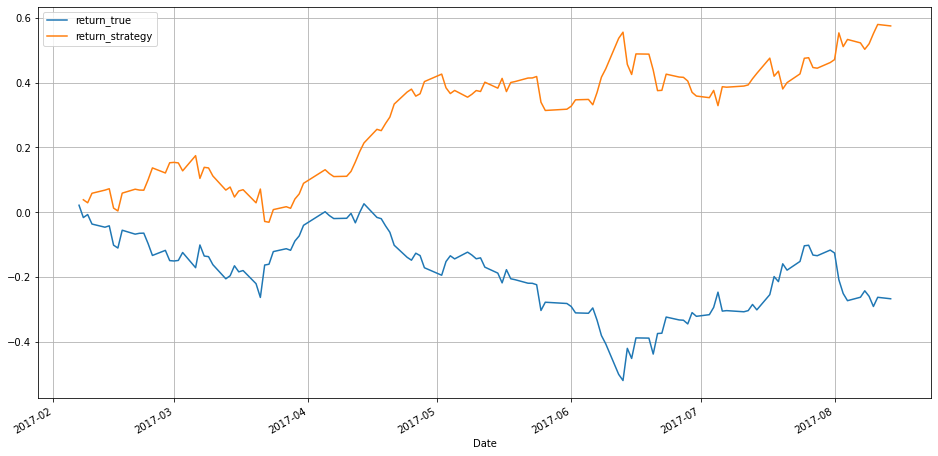

In [6]:
df['position'] = np.sign(df['return_predict'])
df['return_strategy'] = df['position'].shift(1)*df['return_true']

df[['return_true', 'return_strategy']].cumsum().plot(grid=True,
                                                    figsize=(16, 8))

### 一系列回测指标的计算

1. 最大回撤
2. 收益率
3. 夏普比率

In [7]:
# 最大回撤
start_balance = 100000

df['bench_balance'] = start_balance*(df.return_true+1).cumprod()
df['bench_peak'] = df['bench_balance'].cummax()
df['bench_drawdown'] = df['bench_balance']-df['bench_peak']

bench_dd = (df.bench_drawdown/df.bench_peak).min()

df['strategy_balance'] = start_balance*(df.return_strategy+1).cumprod()
df['strategy_peak'] = df['strategy_balance'].cummax()
df['strategy_drawdown'] = df['strategy_balance']-df['strategy_peak']

strategy_dd = (df.strategy_drawdown/df.strategy_peak).min()

print(f'The benchmark drawdown is {round(bench_dd*100, 2)}%.')
print(f'The strategy drawdown is {round(strategy_dd*100, 2)}%.')

The benchmark drawdown is -44.24%.
The strategy drawdown is -21.45%.


In [12]:
# 收益率
bench_return = df.bench_balance[-1]/df.bench_balance[1]-1
strategy_return = df.strategy_balance[-1]/df.strategy_balance[2]-1

print(f'The benchmark return is {round(bench_return*100, 2)}%.')
print(f'The strategy return is {round(strategy_return*100, 2)}%.')

The benchmark return is -30.22%.
The strategy return is 59.38%.


In [9]:
# 夏普比率
rf = 0.04

bench_erp_rf = df['return_true'].sum()/df.__len__()-rf/252
bench_sigmap = df['return_true'].std()

period = 1
bench_sharpe = bench_erp_rf/bench_sigmap*math.sqrt(period)


strategy_erp_rf = df['return_strategy'].sum()/df.__len__()-rf/252
strategy_sigmap = df['return_strategy'].std()

period = 1
strategy_sharpe = strategy_erp_rf/strategy_sigmap*math.sqrt(period)

print(f'The benchmark Sharpe Ratio is {round(bench_sharpe, 2)}.')
print(f'The strategy Sharpe Ratio is {round(strategy_sharpe, 2)}.')

The benchmark Sharpe Ratio is -0.07.
The strategy Sharpe Ratio is 0.13.
